# Generative Adversarial Networks (GAN)

This notebook exemplifies the Generative Adversarial Nets

Ref.: Goodfellow, et. al. 
      https://arxiv.org/pdf/1406.2661
      
It implements a GAN and illustrates it for the (simplest) case
that the model generates a random gaussian-distributed random variable from a uniformly draw random
latend vector (which is one-dimensional).

An interactive plot visualises how the network learns, i.e., how the discriminator and the generator 
competes. The discriminator tries to predict whether a given example is from the real data or from
the generator. The generator, however, tries to fool the discriminator. For this it lears the 
distribution of the real data.

In [1]:
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt, cm, lines

from show_graph import show

/home/daniel/.anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# The model


In [2]:
class MultiLayerPerceptron:
    """A (fully-connected) multi-layer perceptron
    
    Args:
        inputs (tf.Tensor): the inputs of the network, at least two dimensions
            where the last one is the dimension of the inputs
        unit_sizes (List[int]): the number of units in each layer, the last
            number is the output dimension.
        dense_kwargs: arguments get passed to dense layer
    """
    def __init__(self, unit_sizes, **dense_kwargs):
        self._dense_layers = [tf.layers.Dense(units, activation=tf.nn.sigmoid, **dense_kwargs) 
                              for units in unit_sizes]

    def __call__(self, inputs):
        """Applies this operation to inputs
        
        Args:
            inputs (tf.Tensor): the inputs
        
        Returns:
            The outputs (as tf.Tensor). The shape are the same as inputs
            except for the last dimension, which is given by the output dim.
        """     
        activations = inputs
        for layer in self._dense_layers:
            activations = layer(activations)
        return activations

The following is the implementation of the GAN. Its graph is illustated below.

In [3]:
class GenerativeAdversarialNet:
    """Generative Adversarial Net
    
    Args:
        latent_variable (tf.Tensor [batch_size, latent_space_dim]):
            the noise draw from any prior.
        data (tf.Tensor [batch_size, data_space_dim])
            a batch of (real) data which the model shall learn to reproduce
        generator (func(inputs: tf.Tensor)) -> tf.Tensor:
            this function builds the generator, where `inputs` is a 
            tf.Tensor (the latent variable) of shape (None, latent_space_dim).
            The output of the function must have dimension 
            [batchsize, data_space_dim],
        discriminator (func(inputs: tf.Tensor)) -> tf.Tensor:
            this function builds the discriminator, where `inputs` is a 
            tf.Tensor (either data or samples) of shape 
            (batch_size, output_dim). The output must have shape of 
            (batch_size, 1).
            
    Attributes:
        data (tf.Tensor): the batch of (real) data
        samples (tf.Tensor): the batch of (generated) samples
        latent_variable: the batch of latent variables randomly drawn
        discriminator_train_op (tf.Operation): operation to update
            the paramters of the discriminator
        generator_train_op (tf.Operation): operation to update
            the parameters of the generator
    """
    LEARNING_RATE_DISCRIMINATOR = 0.001
    LEARNING_RATE_GENERATOR = 0.001
    DISCRIMINATOR_SCOPE = 'discriminator'
    GENERATOR_SCOPE = 'generator'
    
    def __init__(self, latent_variable, data, 
                 generator, discriminator):
        self.latent_variable = latent_variable
        self.data = data
        with tf.variable_scope(self.GENERATOR_SCOPE):
            self.samples = generator(self.latent_variable)
        with tf.variable_scope(self.DISCRIMINATOR_SCOPE):
            self.classified_data = discriminator(self.data)
            self.classified_samples = discriminator(self.samples)
        with tf.variable_scope('discriminator_loss'):
            self._discriminator_loss = (
                - tf.reduce_mean(tf.log(self.classified_data)) 
                - tf.reduce_mean(tf.log(1 - self.classified_samples)))
        with tf.variable_scope('generator_loss'):
            self._generator_loss = - tf.reduce_mean(tf.log(self.classified_samples))
        with tf.variable_scope('training'):
            self.discriminator_train_op = self._get_discriminator_updater(self._discriminator_loss)
            self.generator_train_op = self._get_generator_updater(self._generator_loss)
   
    def _get_discriminator_updater(self, loss):
        """tf.Operation: performs one SGD on the discriminator"""
        train_var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                                           scope=self.DISCRIMINATOR_SCOPE)
        optimizer = tf.train.AdamOptimizer(
            learning_rate=self.LEARNING_RATE_DISCRIMINATOR)
        return optimizer.minimize(
            loss,
            var_list=train_var_list)

    def _get_generator_updater(self, loss):
        """tf.Operation: performs one SGD on the generator"""  
        train_var_list = tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, 
            scope=self.GENERATOR_SCOPE)
        optimizer = tf.train.AdamOptimizer(
            learning_rate=self.LEARNING_RATE_GENERATOR)
        return optimizer.minimize(
            loss,
            var_list=train_var_list)

In [4]:
latent_space_dim = 1
mean = 0.3
stddev = 0.1
default_batchsize = 64

tf.reset_default_graph()
batch_size = tf.placeholder_with_default(default_batchsize, name="batch_size", shape=[])
with tf.variable_scope("data"):
    data = tf.random_normal(shape=[batch_size, 1], mean=mean, stddev=stddev)

model = GenerativeAdversarialNet(
    latent_variable=tf.random_uniform([batch_size, latent_space_dim]),
    data=data, 
    generator=MultiLayerPerceptron([10, 20, 10, 1]),
    discriminator=MultiLayerPerceptron([10, 20, 10, 1]))

The discriminator gets samples from either the data and the generator. The discriminator_train_op improves the discriminator to classify inputs correctly as samples or data. The generator_train_op improves the generator such that the discriminator can be fooled and samples are classified as real data.

In [5]:
# show()  # uncomment to see the graph in Tensorboard visualization

In [6]:
session = tf.InteractiveSession()
session.run(tf.global_variables_initializer())

In [7]:
class InteractivePlot:
    """Interactive plot which monitors the training progress
    
    Two panels are shown. The upper panel shows the data
    generating distribution, the generative distribution, and
    the discriminative distrubtion. The lower panel shows the
    mapping from the noise to the sample.

    """
    def __init__(self, x, z, data_distribution):
        """
        Args:
            x (array): the common x-value for all signals
            signal (array like x): the data generating distribution
            target (array like x): generative distribution
            prediction_init (array like x): initial prediction to
                shown in lower panel. This can be updated via update()
        """
        plt.ion()
        self.fig = plt.figure()
        
        self.x = x
        self.z = z
        
        # upper subplot
        ax_distribution = plt.subplot(211)
        ax_distribution.set_ylabel("probability p")
        ax_distribution.set_xlim(min(x), max(x))
        ax_distribution.set_ylim(0, 5)
        
        # lower sybplot
        ax_generator_map = plt.subplot(212, sharex=ax_distribution)
        ax_generator_map.set_xlim(min(x), max(x))
        ax_generator_map.set_ylim(0, 1)
        ax_generator_map.set_xlabel("data space x")
        ax_generator_map.set_ylabel("latent variable z")
    
        # lines
        self.data_distribution = self._new_line_in_subplot(
            ax_distribution, args={'c': 'k', 'label': "data generating distribution"})
        self.data_distribution.set_xdata(x)
        self.data_distribution.set_ydata(data_distribution)
        
        self.generator_map = self._new_line_in_subplot(
            ax_generator_map,  args={'c': 'b', 'label': "mapping G(z): noise z to data x"}) 
        
        self.generative_distribution = self._new_line_in_subplot(
            ax_distribution, args={'c': 'b', 'label': "generative distribution"})
        
        self.discriminator = self._new_line_in_subplot(
            ax_distribution, args={'c': 'g', 'label': "discriminative distribution D"})
        
      
        ax_distribution.legend()
        ax_generator_map.legend()
        #plt.show()        
        self.fig.canvas.draw()

        
    @classmethod    
    def _new_line_in_subplot(cls, subplot, args):
        line = lines.Line2D([], [], **args)
        subplot.add_line(line)
        return line

    def update(self, generative_distribution, discriminative_distribution):
        """Updates the distrubtions
        
        Args:
            generative_distribution:
            discriminative_distribution: 
        """
        self.generator_map.set_ydata(self.z)
        self.discriminator.set_xdata(self.x)
        tmp = np.zeros(len(generative_distribution)+1)
        tmp[0] = generative_distribution[0]
        tmp[-1] = generative_distribution[-1]
        tmp[1:-1] = (generative_distribution[1:] + generative_distribution[:-1])/2
        self.generative_distribution.set_xdata(tmp)
            
        
        self.discriminator.set_ydata(discriminative_distribution)
        self.generator_map.set_xdata(generative_distribution)
        
        tmp = np.zeros(len(generative_distribution)+1)
        tmp[0] = 0
        tmp[-1] = 0
        tmp[1:-1] = abs(np.diff(self.x)/np.diff(generative_distribution))

        self.generative_distribution.set_ydata(tmp)
        generative_distribution
        self.fig.canvas.draw()

In [8]:
def plot():
    generator_map, discriminator_data = session.run(
        [model.samples, model.classified_data],
        feed_dict={model.latent_variable: np.expand_dims(iplot.z, axis=1),
                   model.data: np.expand_dims(iplot.x, axis=1)})

    iplot.update(discriminative_distribution=discriminator_data,
                 generative_distribution=generator_map.reshape(-1))

The generative distribution approaches the data generating distribution. Note that it does not apprach completely, probably since the inverted cumulative of a gaussian is hardly expressible as weighted sum of sigmoids.

<IPython.core.display.Javascript object>


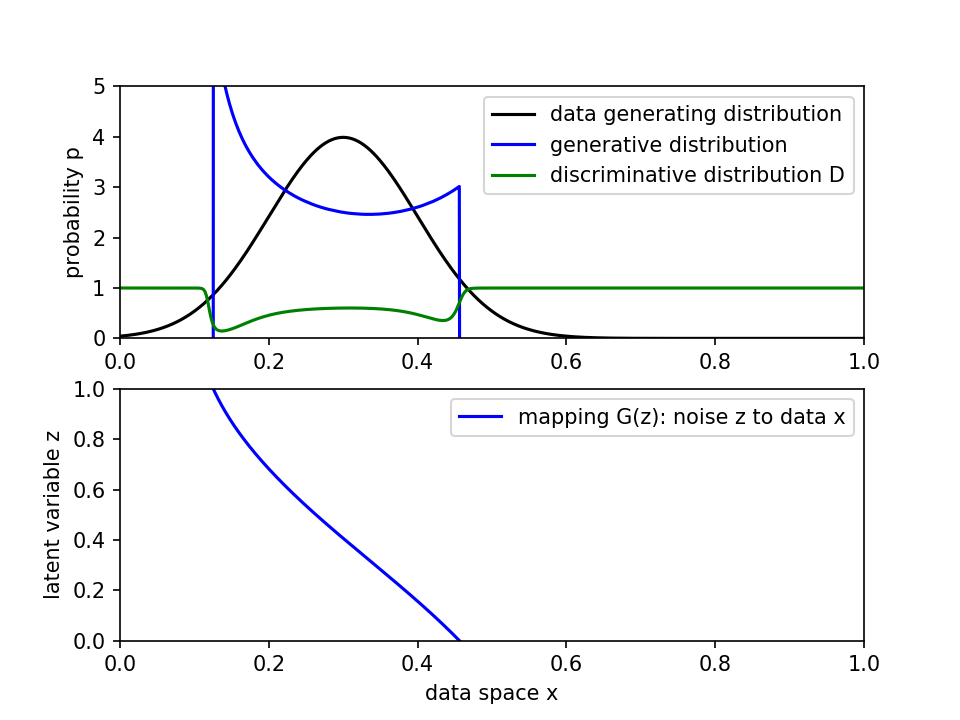

In [9]:
session.run(tf.global_variables_initializer())
def gaussian(x, mean, stddev):
    """A gaussian function with mean and standard deviation str_dev"""
    return 1/((2*np.pi)**0.5 * stddev) * np.exp(-(x - mean)**2 / (2 * stddev**2))

x = z = np.linspace(0, 1, 500)

%matplotlib notebook
iplot = InteractivePlot(
    x=x, z=z,
    data_distribution=gaussian(x, mean, stddev))

for i in range(3000):
    for _ in range(10):
        session.run(model.discriminator_train_op)
    session.run(model.generator_train_op)
    if i % 10 == 0:
        plot()

# Conclusion

We have trained a GAN, i.e., a generator which samples data which looks like the one from the real data distribution (given by the training data).